# Predictive Maintenance using Machine Learning on Sagemaker
*Part 4 - Model training*

## Initialization
---
Directory structure to run this notebook:
```
nasa-turbofan-rul-deepar
|
+--- data
|   |
|   +--- interim: intermediate data we can manipulate and process
|   |
|   \--- raw: *immutable* data downloaded from the source website
|
+--- notebooks: all the notebooks are positionned here
|
+--- src: utility python modules are stored here
```
### Imports

In [1]:
%load_ext autoreload

import os
import errno
import random
import sys
import numpy as np
import mxnet as mx
import mxnet.gluon as G
import matplotlib.pyplot as plt
import seaborn as sns

# Initializing random seeds:
random.seed(42)
np.random.seed(42)
sns.set_style('darkgrid')
sys.path.append('../src')

%matplotlib inline
%autoreload 2

Importing Sagemaker & AWS specific libraries: we also obtain the IAM role arn used to give training and hosting access to your data. Here we use the get_execution_role function to obtain the role arn which was specified when creating the notebook. We also configure the container image to be used for the region that we are running in.

In [2]:
import boto3
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
role = get_execution_role()

### Loading data from the previous notebook

In [101]:
# Load data from the notebook local storage:
%store -r train_sequences
%store -r train_labels
%store -r test_sequences
%store -r test_labels
%store -r label_scaler
%store -r unit_span

## Build the LSTM model for forecasting
---
Model definition

In [4]:
class RULPredictionNet(G.nn.HybridSequential):
    def __init__(self, **kwargs):
        super(RULPredictionNet, self).__init__(**kwargs)
        
        self.net = G.nn.HybridSequential()
        with self.net.name_scope():
            self.net.add(G.rnn.LSTM(hidden_size=40, num_layers=3))
            self.net.add(G.nn.Dense(units=1))
            
        #with self.name_scope():
        #    self.lstm = G.rnn.LSTM(hidden_size=40, num_layers=3)#, dropout=0.2)
        #    self.out = G.nn.Dense(units=1)
            
    def forward(self, x):
        #x = self.lstm(x)
        #x = self.out(x)
        #return x
    
        x = self.net(x)
        
        return x
    
net = RULPredictionNet().net
net.hybridize()
print(net)

HybridSequential(
  (0): LSTM(None -> 40, TNC, num_layers=3)
  (1): Dense(None -> 1, linear)
)


Initialize the model to a device:

In [5]:
device = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)
net.initialize(mx.init.Xavier(), ctx=device)

Define sequence iterator:

In [6]:
X_train = mx.nd.array(train_sequences)
y_train = mx.nd.array(train_labels)

train_dataset = G.data.dataset.ArrayDataset(X_train, y_train)
train_loader = G.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

Define the training parameters:

In [7]:
trainer = G.Trainer(
    params=net.collect_params(),
    optimizer='adam',
    optimizer_params={'learning_rate': 0.001},
)

num_epochs = 1

Main training loops:

In [8]:
from mxnet.gluon.contrib.estimator import estimator
from mxnet.gluon.contrib.estimator.event_handler import TrainBegin, TrainEnd, EpochEnd, CheckpointHandler

# Define the estimator, by passing to it the model, loss function, metrics, trainer object and context
estimator = estimator.Estimator(
    net=net,
    loss=G.loss.L2Loss(),
    train_metrics=[mx.metric.RMSE(), mx.metric.Loss()],
    trainer=trainer,
    context=device
)

checkpoint_handler = CheckpointHandler(
    model_dir='./',
    model_prefix='my_model',
    monitor=estimator.train_metrics[0],
    save_best=True,
    mode='min'
)

In [9]:
estimator.fit(train_data=train_loader, epochs=num_epochs, event_handlers=[checkpoint_handler])

Training begin: using optimizer Adam with current learning rate 0.0010 
Train for 1 epochs.
[Epoch 0] Begin, current learning rate: 0.0010
[Epoch 0] Finished in 15.718s, training rmse: 0.1910, training loss: 0.0214
Train finished using total 15s with 1 epochs. training rmse: 0.1910, training loss: 0.0214


In [25]:
model_dir = '.'
model_name = 'my_model'
for files in os.listdir(model_dir):
    if (files[:len(model_name + '-epoch')] == model_name + '-epoch'):
        os.remove(files)

In [35]:
#[Epoch 399] Finished in 9.233s, training mse: 0.0049, training rmse: 0.0690, training loss: 0.0024
#Train finished using total 3224s with 400 epochs. training mse: 0.0049, training rmse: 0.0690, training loss: 0.0024

training_rmse = estimator.train_metrics[0].get()
training_loss = estimator.train_metrics[1].get()
print('RMSE (normal)', training_rmse[1])
print('RMSE (original space)', label_scaler.inverse_transform(np.array(training_rmse[1]).reshape(-1, 1))[0][0])
print('Loss', training_loss[1])

RMSE (normal) 0.19279139478538568
RMSE (original space) 25.062881322100136
Loss 0.02152192325468587


In [105]:
label_scaler.inverse_transform(np.array([0.125004]).reshape(-1,1))[0][0]

16.250519999999998

## Making some predictions
---

In [16]:
from lstm_utils import get_unit_predictions, plot_unit_predictions

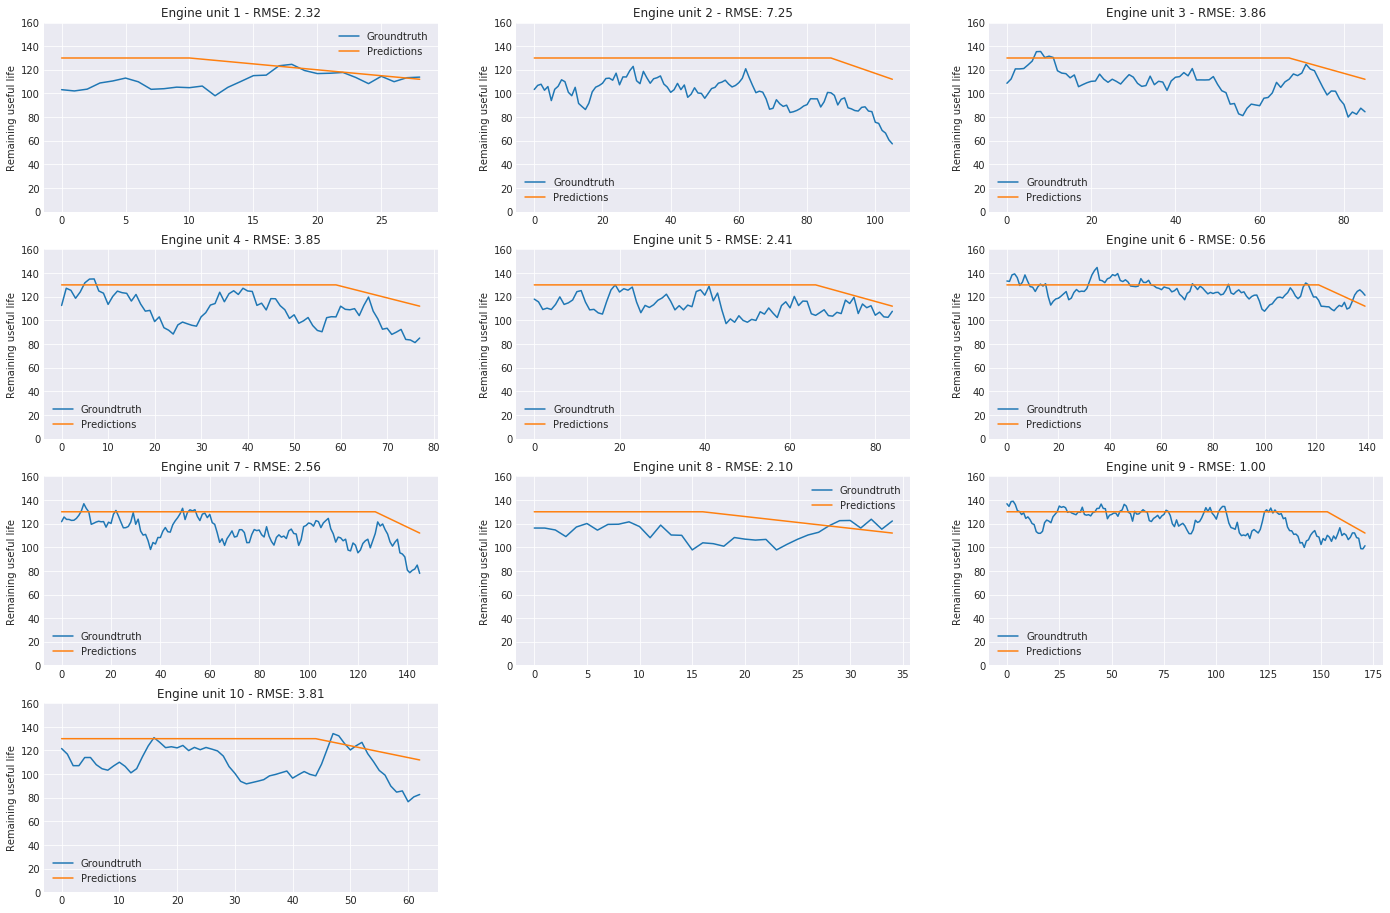

In [22]:
#for index in range(len(unit_span)):
figure = plt.figure(figsize=(24,16))
for index in range(10):
    unit_id = index + 1
    plt.subplot(4, 3, unit_id)
    original_rul, predictions = get_unit_predictions(unit_id, test_sequences, test_labels, unit_span, net)
    plot_unit_predictions(unit_id, original_rul, predictions, label_scaler)